# 項目分析

テストを実施したあと、モデルをあてはめてパラメータを推定する前の段階で簡単に計算できる指標群で項目の良し悪しを考察できる。

In [126]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def generate_irt_2pl_data(num_persons=1000, num_items=20, seed=42):
    """2PLM用の二値反応サンプルデータセットを生成する"""
    np.random.seed(seed)

    # 潜在能力 θ を標準正規分布から生成
    theta = np.random.normal(loc=0, scale=1, size=num_persons)

    # 識別力 a ~ N(0, 1)
    a = np.random.normal(size=num_items)

    # 困難度 b ~ N(0, 1)
    b = np.random.normal(loc=0, scale=1, size=num_items)

    # 応答行列を初期化
    response_matrix = np.zeros((num_persons, num_items))

    for i in range(num_persons):
        for j in range(num_items):
            p = 1 / (1 + np.exp(-a[j] * (theta[i] - b[j])))  # 正答確率
            response_matrix[i, j] = np.random.binomial(n=1, p=p)  # 0 or 1

    # DataFrameとして返す（行=受験者, 列=項目）
    responses = pd.DataFrame(response_matrix, columns=[f"item_{j+1}" for j in range(num_items)]).astype(int)
    return responses, a, b, theta


# サンプルデータの生成
responses, a, b, theta = generate_irt_2pl_data(num_persons=500, num_items=20)

## 項目困難度 / 通過率

古典テスト理論における項目困難度は、正答率のこと。

わかりやすさのために「通過率」と呼ばれることもある。各設問の正答の容易さを示す。


In [64]:
responses.mean().to_frame("mean").head()

,mean
item_1,0.788
item_2,0.336
item_3,0.302
item_4,0.422
item_5,0.372


## 項目識別力

古典テスト理論における項目識別力は、素点（テスト得点）と各項目得点の相関をみるもの。

テストで測りたい能力を大まかに表すものである素点に対し、各項目が相関している（能力を測るのに貢献している）ことを確かめる。


In [65]:
df = responses.copy()
df["raw_score"] = responses.sum(axis=1)

from ordinalcorr import biserial

results = []
for item_col in df.filter(like="item_").columns:
    results.append({
        "item": item_col,
        "corr": biserial(df["raw_score"], df[item_col]),
    })
pd.DataFrame(results).head().round(3)

,item,corr
0,item_1,0.127
1,item_2,0.024
2,item_3,0.466
3,item_4,0.306
4,item_5,0.346


## 項目特性図 / トレースライン

各被験者の素点やテスト得点（をビンに区切ったもの）を横軸に、素点ごとの各選択肢の選択割合を縦軸にした折れ線グラフ。

素点が高くなるに従って項目の正答率も上昇していれば識別力の高い項目と判断される。

逆に、素点が低い受験者のほうが正答率が高いような設問は識別力が低い疑いがある


[Text(0.5, 1.0, '識別力が低い項目')]

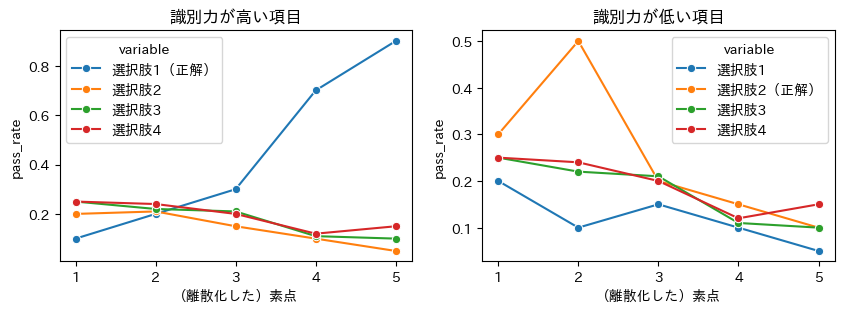

In [124]:
import matplotlib.pyplot as plt
import matplotlib_fontja
import seaborn as sns

fig, axes = plt.subplots(figsize=[10, 3], ncols=2)

# 1
temp = pd.DataFrame({
    "（離散化した）素点": [1, 2, 3, 4, 5],
    "選択肢1（正解）": [0.1, 0.2, 0.3, 0.7, 0.9],
    "選択肢2": [0.2, 0.21, 0.15, 0.1, 0.05],
    "選択肢3": [0.25, 0.22, 0.21, 0.11, 0.1],
    "選択肢4": [0.25, 0.24, 0.2, 0.12, 0.15],
})

sns.lineplot(
    data=temp.melt(id_vars="（離散化した）素点", value_name="pass_rate"),
    x="（離散化した）素点", y="pass_rate", hue="variable", marker="o", ax=axes[0],
)
axes[0].set(title="識別力が高い項目")

# 2
temp = pd.DataFrame({
    "（離散化した）素点": [1, 2, 3, 4, 5],
    "選択肢1": [0.2, 0.1, 0.15, 0.1, 0.05],
    "選択肢2（正解）": [0.3, 0.5, 0.2, 0.15, 0.1],
    "選択肢3": [0.25, 0.22, 0.21, 0.11, 0.1],
    "選択肢4": [0.25, 0.24, 0.2, 0.12, 0.15],
})

sns.lineplot(
    data=temp.melt(id_vars="（離散化した）素点", value_name="pass_rate"),
    x="（離散化した）素点", y="pass_rate", hue="variable", marker="o", ax=axes[1],
)
axes[1].set(title="識別力が低い項目")


/tmp/ipykernel_7211/1452260162.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  stats = df.groupby("raw_score")[item_cols].mean().reset_index()
/tmp/ipykernel_7211/1452260162.py:10: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  stats["raw_score"] = stats["raw_score"].replace(dict(zip(rs.cat.categories, rs.cat.codes))).astype(str)
/tmp/ipykernel_7211/1452260162.py:10: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change

<Axes: xlabel='raw_score', ylabel='pass_rate'>

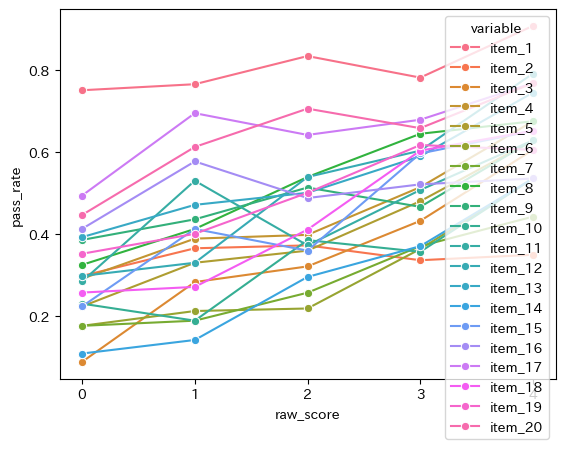

In [125]:
# 簡易的に2択の設問と仮定して、正解のほうを選べた率を表している
df = responses.copy()
df["raw_score"] = responses.sum(axis=1)
df["raw_score"] = pd.qcut(df["raw_score"], 5)

item_cols = df.filter(like="item_").columns
stats = df.groupby("raw_score")[item_cols].mean().reset_index()

rs = stats["raw_score"]
stats["raw_score"] = stats["raw_score"].replace(dict(zip(rs.cat.categories, rs.cat.codes))).astype(str)

import seaborn as sns
sns.lineplot(
    data=stats.melt(id_vars="raw_score", value_name="pass_rate"),
    x="raw_score", y="pass_rate", hue="variable",
    marker="o"
)